In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import timeit

# 2
Реализуйте произведение матриц $A\in Mat(N\times K)$, $B\in Mat(K\times M)$ согласно определению
$$
C_{n,m}=\sum_{k=1}^K A_{n,k}B_{k,m}.
$$
Сравните быстродействие реализаций на основе numpy.sum, с помощью numba и стандартный метод numpy.dot.
Насколько полно используется процессор? 
Сколько используется памяти?

In [5]:
@nb.njit('float64[:,:](float64[:,:],float64[:,:])', parallel = False)
def mat_mul(mat_1, mat_2):
    row_1, col_1 = mat_1.shape
    _, col_2 = mat_2.shape
    mat_3 = np.empty((row_1, col_2), dtype = np.float64)
    for i in range(row_1):
        for j in range(col_2):
            for k in range(col_1):
                mat_3[i, j] += mat_1[i, k] * mat_2[k, j]
    return mat_3

In [16]:
# Matrices dimensions
A_row = 100
A_col_max = 20000
A_col_min = 2000


STEP = 200
REPEAT_NUMBER = 10

# matrix be has dimensions A_col_max, A_row
A = np.random.random((A_row, A_col_max))
B = np.random.random((A_col_max, A_row))

In [7]:
#time data generation
data_range = range(A_col_min, int(A_col_max / 3), STEP)

def time_reg(n):
    return timeit.timeit(stmt = "mat_mul(A[:, :%(n)s], B[:%(n)s, :])" % {'n': n},
                         globals = {'mat_mul': mat_mul, 'A': A, 'B': B}, number = REPEAT_NUMBER)

In [7]:
time_list = list(time_reg(n) for n in data_range)
points_list = list(n for n in data_range)

In [8]:
def time_reg_no_slice(n):
    return timeit.timeit(stmt = "mat_mul(A, B)",
                         globals = {'mat_mul': mat_mul, 'A': A[:, : n], 'B': B[: n, :]}, number = REPEAT_NUMBER)

In [9]:
time_list_no_slice = list(time_reg_no_slice(n) for n in data_range)

In [10]:
#implement dot multiplication

dot_time_list = list(timeit.timeit(stmt = "A[:, :%(n)s].dot(B[:%(n)s, :])" % {'n': n},
                    globals = {'A': A, 'B': B}, number = 1) for n in data_range)

In [11]:
#implement np.sum

def mat_np_sum(mat_1, mat_2):
    row_1, _ = mat_1.shape
    _, col_2 = mat_2.shape
    mat_3 = np.empty((row_1, col_2), dtype = np.float64)
    for i in range(row_1):
        for j in range(col_2):
            mat_3[i, j] = np.multiply(A[i, :], B[:, j])
    return mat_3

In [12]:
def sum_time_reg(n):
    return timeit.timeit(stmt = "mat_np_sum(A[:, :%(n)s], B[:%(n)s, :])" % {'n': n},
                         globals = {'mat_np_sum': mat_np_sum, 'A': A, 'B': B}, number = REPEAT_NUMBER)

sum_time_list = list(time_reg(n) for n in data_range)

# 3
Составьте модель использования вычислительных ресурсов функцией на основе numba.jit из предыдущего пункта. Размеры матриц должны быть параметрами модели. Проведите вычислительные эксперименты, чтобы подобрать параметры модели. Экстраполируйте результат на большие матрицы, сделайте экспериментальную проверку.

В общем случае модели мы можем менять все три параметра матриц: $M, N, K$. Общий вид модели:

$$
T(M,N,K))= a\cdot(MNK) + b\cdot(MN) + c\cdot(NK) + d\cdot(MK) + e\cdot(M) + f\cdot(N) + g\cdot(K) + h
$$

Наличие свободного члена обусловлено процессами, которые не зависят от размера массива.


Посчитаем упрощённую модель, когда мы изменяем только общий размер матриц. Рассмотрим две матрицы размеров $(M, N)$ и $(N, K)$ Читаем строку матрицы A за $O(N)$, столбец B за $O(N)$, складываем элементы за $O(N)$, так мы делаем $M \cdot K$ раз. Также есть ещё какое-то время на запуск: $O(1)$. Зависимость от N будет линейной и примет вид:

$T(N) = a N + b$

Найдём константы

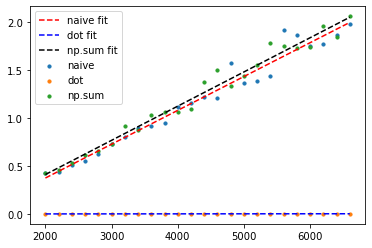

In [14]:

dot_time = np.array(dot_time_list)
sum_time = np.array(sum_time_list)

naive_fit_coeffs = np.polyfit(points_list, time_list, 1)
naive_polynomial = np.poly1d(naive_fit_coeffs)
naive_fit = naive_polynomial(N_ax)

dot_coeffs = np.polyfit(points_list, dot_time_list, 1)
dot_pol = np.poly1d(dot_coeffs)
dot_fit = dot_pol(N_ax)

sum_coeffs = np.polyfit(points_list, sum_time_list, 1)
sum_pol = np.poly1d(sum_coeffs)
sum_fit = sum_pol(N_ax)

plt.scatter(points, naive, s = 10, label = 'naive')
plt.plot(N_ax, naive_fit, '--r', label = "naive fit")
plt.scatter(points, dot_time, s = 10, label = 'dot')
plt.plot(N_ax, dot_fit, '--b', label = "dot fit")
plt.scatter(points, sum_time, s = 10, label = "np.sum")
plt.plot(N_ax, sum_fit, '--k', label = "np.sum fit")
plt.legend()

In [15]:
from sklearn.metrics import r2_score

print('Determination coefficient for naive: ', r2_score(naive, naive_fit))
print('Determination coefficient for sum: ', r2_score(sum_time, sum_fit))

Determination coefficient for naive:  0.9654620659814854
Determination coefficient for sum:  0.9778903570347318


Сами коэффициенты для простой реализации с numba и для реализации np.dot

In [16]:
print('Naive: ', naive_fit_coeffs)
print('Dot: ', dot_coeffs)

Naive:  [ 0.00035307 -0.33011565]
Dot:  [3.45970870e-07 6.39000261e-04]


Посмотрим, как ведёт себя модель при экстраполяции:

In [17]:
extra_data_range = range(int(A_col_max / 2), A_col_max, STEP * 5)

time = np.array(list(time_reg(n) for n in extra_data_range))
points = np.array(list(extra_data_range))

time_fit = naive_polynomial(points)

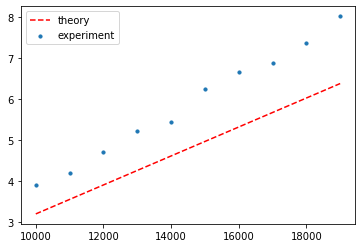

In [18]:
plt.scatter(points, time, s = 10, label = "experiment")
plt.plot(points, time_fit, '--r', label = "theory")
plt.legend()

In [19]:
print('Determination coefficient for naive: ', r2_score(time, time_fit))

Determination coefficient for naive:  0.2723279215370459


Видим, что при экстраполяции до 2N модель работает недостаточно хорошо, экспериментальные значения идут выше предсказанного.

# 4
В простейшем алгоритме произведения матриц используются три цикла: перебирающие элементы $n$ и $m$  матрицы $C$
и суммирующие по $k$. 
Сравните время перемножения матриц в зависимости от порядка циклов.
Оцените объем кэшей разных уровней, проводя эксперименты для матриц разного размера.

In [20]:
A_row = 100
A_col_max = 26000
A_col_min = 2000

# matrix be has dimensions A_col_max, A_row
A = np.random.random((A_row, A_col_max))
B = np.random.random((A_col_max, A_row))

cache_data_range = range(10000, 20000, 600)

def time_reg(n):
    return timeit.timeit(stmt = "mat_mul(A[:, :%(n)s], B[:%(n)s, :])" % {'n': n},
                         globals = {'mat_mul': mat_mul, 'A': A, 'B': B}, number = 40)

time_list = list(time_reg(n) for n in cache_data_range)
points_list = list(cache_data_range)

plt.scatter(points_list, time_list, s = 5, label = 'naive')

plt.legend()

KeyboardInterrupt: 

Здесь заметны "ступеньки", когда время вычисления растёт быстрее. Скачки наблюдаются при $N = 15000, \; N = 17000$, значит кэш порядка 120 - 144 Кб. Обратимся к спецификации.

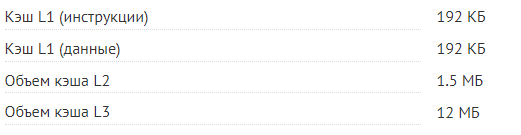

В этих ступеньках за пределы кэша мы не выходим.

Теперь посмотрим на поведение зависимости времени от размера при смене порядка изменяющегося индекса

In [2]:
@nb.njit('float64[:,:](float64[:,:],float64[:,:])')
def mat_mul_alt(mat_1, mat_2):
    row_1, col_1 = mat_1.shape
    _, col_2 = mat_2.shape
    mat_3 = np.empty((row_1, col_2), dtype = np.float64)
    for i in range(col_2):
        for j in range(row_1):
            for k in range(col_1):
                mat_3[j, i] += mat_1[j, k] * mat_2[k, i]
    return mat_3

In [17]:

A_col = 100
A_row_max = 26000
A_row_min = 2000
data_range = range(A_col_min, int(A_col_max / 3), STEP)

# matrix be has dimensions A_col_max, A_row
A = np.random.random((A_row, A_col_max))
B = np.random.random((A_col_max, A_row))

In [18]:
def time_reg_alt(n):
    return timeit.timeit(stmt = "mat_mul_alt(A[:, :%(n)s], B[:%(n)s, :])" % {'n': n},
                         globals = {'mat_mul_alt': mat_mul_alt, 'A': A, 'B': B}, number = REPEAT_NUMBER)

points_list = list(data_range)
time_list = list(time_reg(n) for n in data_range)
time_alt_list = list(time_reg_alt(n) for n in data_range)

KeyboardInterrupt: 

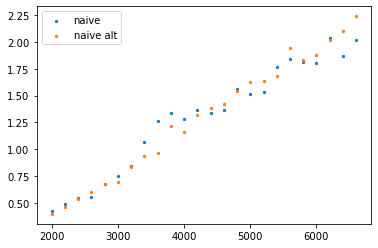

In [11]:
plt.scatter(points_list, time_list, s = 5, label = "naive")
plt.scatter(points_list, time_alt_list, s = 5, label = "naive alt")
plt.legend()

При применении numba значительной разницы нет при смене порядка

# 5
Обновите функцию для перемножения матриц, используя несколько потоков с помощью numba.prange.
Обновите модель использования вычислительных ресурсов, принимая во внимание число потоков.
Оцените параметры модели из эксперимента.
Какое [параллельное ускорение](https://en.wikipedia.org/wiki/Amdahl%27s_law) вы получили?

In [ ]:
@nb.njit('float64[:,:](float64[:,:],float64[:,:])', parallel = True)
def mat_mul_parallel(mat_1, mat_2):
    row_1, col_1 = mat_1.shape
    _, col_2 = mat_2.shape
    mat_3 = np.empty((row_1, col_2), dtype = np.float64)
    for i in nb.prange(row_1):
        for j in nb.prange(col_2):
            for k in nb.prange(col_1):
                mat_3[i, j] += mat_1[i, k] * mat_2[k, j]
    return mat_3

In [ ]:
def time_reg_parallel(n, threads):
    return timeit.timeit(stmt = "mat_mul_parallel(A[:, :%(n)s], B[:%(n)s, :])" % {'n': n},
                         globals = {'mat_mul_parallel': mat_mul_parallel, 'A': A, 'B': B, 'nb.set_num_threads': nb.set_num_threads}, number = REPEAT_NUMBER, setup = """
from numba import set_num_threads
set_num_threads(%s)
"""%threads)

In [ ]:
data_range_parallel = range(100, 1000, 200)
parallel_points = list(n for n in data_range_parallel)

time_list = list(time_reg(n) for n in data_range_parallel)
time_parallel_list_2 = list(time_reg_parallel(n, 2) for n in data_range_parallel)
time_parallel_list_4 = list(time_reg_parallel(n, 4) for n in data_range_parallel)
time_parallel_list_6 = list(time_reg_parallel(n, 6) for n in data_range_parallel)

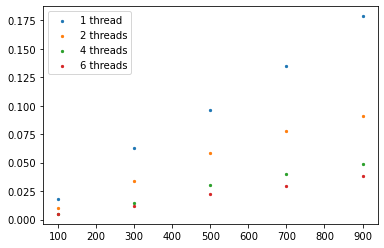

In [ ]:
plt.scatter(parallel_points, time_list, s = 5, label = "1 thread")
plt.scatter(parallel_points, time_parallel_list_2, s = 5, label = "2 threads")
plt.scatter(parallel_points, time_parallel_list_4, s = 5, label = "4 threads")
plt.scatter(parallel_points, time_parallel_list_6, s = 5, label = "6 threads")
plt.legend()

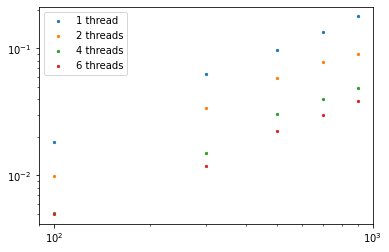

In [ ]:
plt.scatter(parallel_points, time_list, s = 5, label = "1 thread")
plt.scatter(parallel_points, time_parallel_list_2, s = 5, label = "2 threads")
plt.scatter(parallel_points, time_parallel_list_4, s = 5, label = "4 threads")
plt.scatter(parallel_points, time_parallel_list_6, s = 5, label = "6 threads")
plt.yscale('log')
plt.xscale('log')
plt.legend()

С увеличением числа потоков растёт и быстродействие перемножения. Определим коэффициенты линейного приближения и построим соответствующую модель. Для этого измерим время на больших размерах.

In [ ]:
data_range_extra = range(4000, 8000, 200)
points = list(data_range_extra)

threads_6 = list(time_reg_parallel(n, 6) for n in data_range_extra)

parallel_coeffs_6 = np.polyfit(points, threads_6, 1)
parallel_fit_6 = np.poly1d(parallel_coeffs_6)

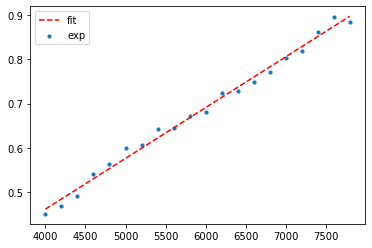

In [ ]:
plt.scatter(points, threads_6, s = 10, label = 'exp')
plt.plot(points, parallel_fit_6(points), '--r', label = 'fit')
plt.legend()

Сами коэффициенты

In [ ]:
print(parallel_coeffs_6)

[0.00011431 0.00523183]


Если сравнить с однопоточными вычислениями

In [ ]:
threads_1 = list(time_reg_parallel(n, 1) for n in data_range_extra)

parallel_coeffs_1 = np.polyfit(points, threads_1, 1)
parallel_fit_1 = np.poly1d(parallel_coeffs_1)

In [ ]:
threads_4 = list(time_reg_parallel(n, 4) for n in data_range_extra)

parallel_coeffs_4 = np.polyfit(points, threads_4, 1)
parallel_fit_4 = np.poly1d(parallel_coeffs_4)

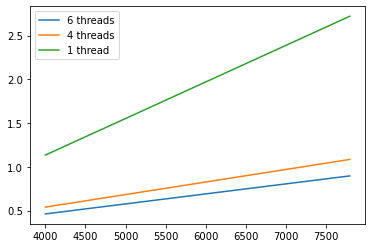

In [ ]:
plt.plot(points, parallel_fit_6(points), label = '6 threads')
plt.plot(points, parallel_fit_4(points), label = '4 threads')
plt.plot(points, parallel_fit_1(points), label = '1 thread')
plt.legend()

In [ ]:
print('1 thread: ', parallel_coeffs_1)
print('4 threads: ', parallel_coeffs_4)
print('6 threads: ', parallel_coeffs_6)
print('a_1 / a_4 = ', parallel_coeffs_1[0] / parallel_coeffs_4[0])
print('a_1 / a_6 = ', parallel_coeffs_1[0] / parallel_coeffs_6[0])

1 thread:  [ 4.17291698e-04 -5.34102197e-01]
4 threads:  [ 0.00014326 -0.03270799]
6 threads:  [0.00011431 0.00523183]
a_1 / a_4 =  2.9128393439502833
a_1 / a_6 =  3.6506217664825913


Получили ускорение более чем в 3 раза.

С ростом числа потоков растёт и быстродействие, значит есть обратная пропорциональность числу потоков. Однако пропорциональность не строгая. Видим, что быстроедйствие 4 потоков и 6 потоков различается не сильно.

$$
T(M,N,K))= (a / p + a_{write})\cdot(MNK) + (b / p + b_{write})\cdot(MN) + (c / p + c_{write})\cdot(NK) + (d / p + d_{write})\cdot(MK) + (e / p + e_{write})\cdot(M) + (f / p + f_{write})\cdot(N) + (g / p + g_{write})\cdot(K) + q \cdot p  + h
$$

В общем случае должен быть коэффициент, отвечающий за выделение ресурсов под использование нескольких потоков. Так что появляется слабая, но прямая зависимость от числа потоков.

# 7
Реализуйте быстрое произведение матриц, например, используйте алгоритм Штрассена.

In [21]:
def strassen(A, B):
    n = len(A)
    if n == 1:
        return A * B
    else:
        # Divide
        A11, A12, A21, A22 = A[: n // 2, : n // 2], A[: n // 2,  n // 2 :], A[ n // 2 :, : n // 2], A[ n // 2 :,  n // 2 :]
        B11, B12, B21, B22 = B[: n // 2, : n // 2], B[: n // 2,  n // 2 :], B[ n // 2 :, : n // 2], B[ n // 2 :,  n // 2 :]

        # Compute
        P1 = strassen(A11 + A22, B11 + B22)
        P2 = strassen(A21 + A22, B11)
        P3 = strassen(A11, B12 - B22)
        P4 = strassen(A22, B21 - B11)
        P5 = strassen(A11 + A12, B22)
        P6 = strassen(A21 - A11, B11 + B12)
        P7 = strassen(A12 - A22, B21 + B22)

        # Compute the result
        C11 = P1 + P4 - P5 + P7
        C12 = P3 + P5
        C21 = P2 + P4
        C22 = P1 - P2 + P3 + P6

        # Combine the result
        C = np.vstack((np.hstack((C11, C12)), np.hstack((C21, C22))))
        return C

In [22]:
A = np.random.random((5000, 10000))
B = np.random.random((10000, 5000))

In [23]:
def strassen_time(n):
    return timeit.timeit(stmt = "strassen(A[:, :%(n)s], B[:%(n)s, :])" % {'n': n},
                         globals = {'strassen': strassen, 'A': A, 'B': B}, number = REPEAT_NUMBER)

In [ ]:
strassen_range = range(5000, 9000, 1000)

points = list(strassen_range)

time_naive = list(time_reg(n) for n in data_range)
time_strassen = list(strassen_time(n) for n in strassen_range)